# 🌀 RealNVP

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/06_normflow/01_realnvp/realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩일 경우 노트북에서 output 디렉토리를 만듭니다.
if 'google.colab' in sys.modules:
    !mkdir output

이 노트북에서는 데모 데이터셋의 분포를 예측하기 위해 RealNVP 신경망을 훈련합니다.

이 코드는 케라스 웹 사이트에 있는 Mandolini Giorgio Maria, Sanna Daniele and Zannini Quirini Giorgio의 훌륭한 [RealNVP 튜토리얼](https://keras.io/examples/generative/real_nvp/)을 참고했습니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

## 0. 파라미터 <a name="parameters"></a>

In [3]:
COUPLING_DIM = 256
COUPLING_LAYERS = 6
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

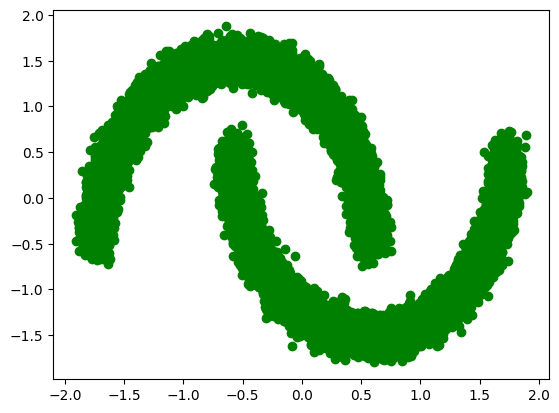

In [4]:
# 데이터 로드
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

## 2. RealNVP 네트워크 구축 <a name="build"></a>

In [5]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=input_dim)

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [6]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

## 3. RealNVP 네트워크 훈련 <a name="train"></a>

In [7]:
# 모델 컴파일 및 훈련
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [8]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # 데이터에서 잠재 공간까지.
        z, _ = model(normalized_data)

        # 잠재 공간에서 데이터까지.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
  4/118 [>.............................] - ETA: 2s - loss: 2.7991   

117/118 [============================>.] - ETA: 0s - loss: 2.4522
Saved to ./output/generated_img_000.png


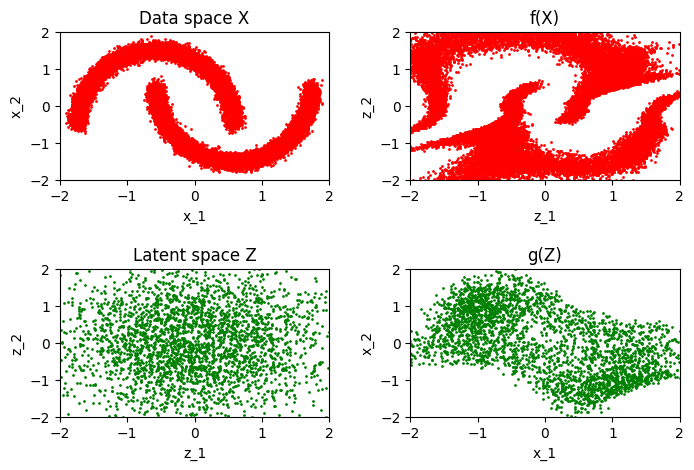

118/118 [==============================] - 29s 52ms/step - loss: 2.4508
Epoch 2/300
118/118 [==============================] - 3s 23ms/step - loss: 2.1353
Epoch 3/300
118/118 [==============================] - 2s 21ms/step - loss: 2.0181
Epoch 4/300
118/118 [==============================] - 2s 21ms/step - loss: 1.8005
Epoch 5/300
118/118 [==============================] - 3s 25ms/step - loss: 1.4633
Epoch 6/300
118/118 [==============================] - 3s 24ms/step - loss: 1.3485
Epoch 7/300
118/118 [==============================] - 2s 21ms/step - loss: 1.3202
Epoch 8/300
118/118 [==============================] - 2s 21ms/step - loss: 1.3018
Epoch 9/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2858
Epoch 10/300
118/118 [==============================] - 3s 27ms/step - loss: 1.2867
Epoch 11/300
117/118 [============================>.] - ETA: 0s - loss: 1.2787
Saved to ./output/generated_img_010.png


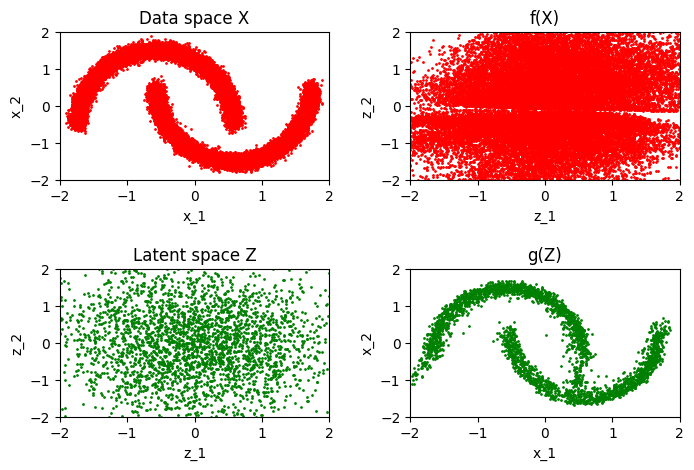

118/118 [==============================] - 4s 33ms/step - loss: 1.2777
Epoch 12/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2691
Epoch 13/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2772
Epoch 14/300
118/118 [==============================] - 3s 28ms/step - loss: 1.2648
Epoch 15/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2615
Epoch 16/300
118/118 [==============================] - 2s 21ms/step - loss: 1.2542
Epoch 17/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2535
Epoch 18/300
118/118 [==============================] - 4s 33ms/step - loss: 1.2464
Epoch 19/300
118/118 [==============================] - 3s 28ms/step - loss: 1.2429
Epoch 20/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2419
Epoch 21/300
117/118 [============================>.] - ETA: 0s - loss: 1.2292
Saved to ./output/generated_img_020.png


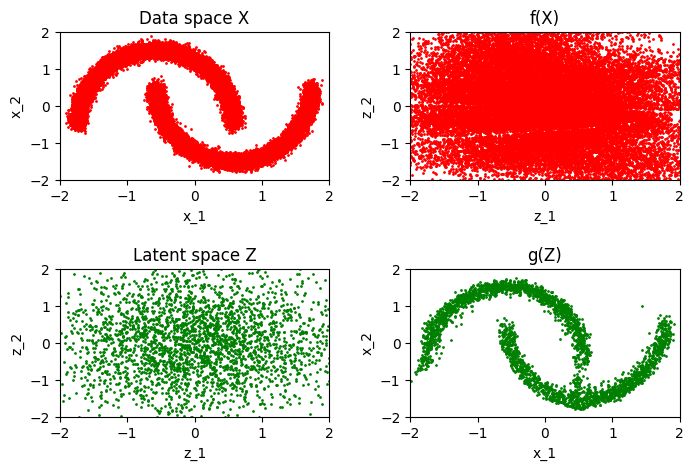

118/118 [==============================] - 4s 35ms/step - loss: 1.2313
Epoch 22/300
118/118 [==============================] - 3s 28ms/step - loss: 1.2438
Epoch 23/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2357
Epoch 24/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2424
Epoch 25/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2290
Epoch 26/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2214
Epoch 27/300
118/118 [==============================] - 3s 27ms/step - loss: 1.2258
Epoch 28/300
118/118 [==============================] - 3s 21ms/step - loss: 1.2230
Epoch 29/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2293
Epoch 30/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2275
Epoch 31/300
117/118 [============================>.] - ETA: 0s - loss: 1.2307
Saved to ./output/generated_img_030.png


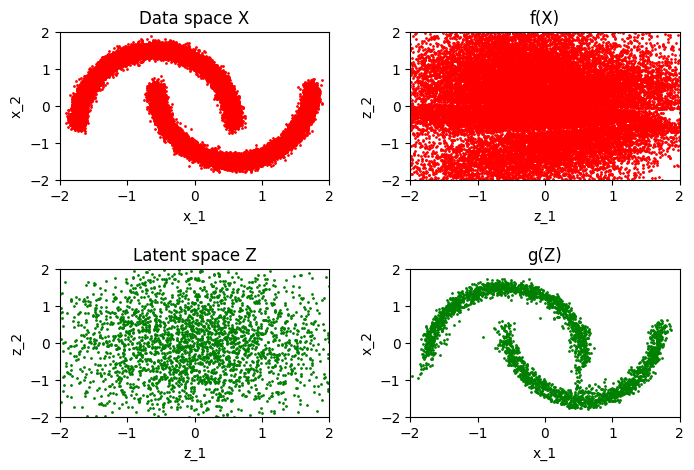

118/118 [==============================] - 5s 43ms/step - loss: 1.2300
Epoch 32/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2205
Epoch 33/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2157
Epoch 34/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2168
Epoch 35/300
118/118 [==============================] - 3s 30ms/step - loss: 1.2173
Epoch 36/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2143
Epoch 37/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2183
Epoch 38/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2165
Epoch 39/300
118/118 [==============================] - 3s 28ms/step - loss: 1.2139
Epoch 40/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2103
Epoch 41/300
118/118 [==============================] - ETA: 0s - loss: 1.2188
Saved to ./output/generated_img_040.png


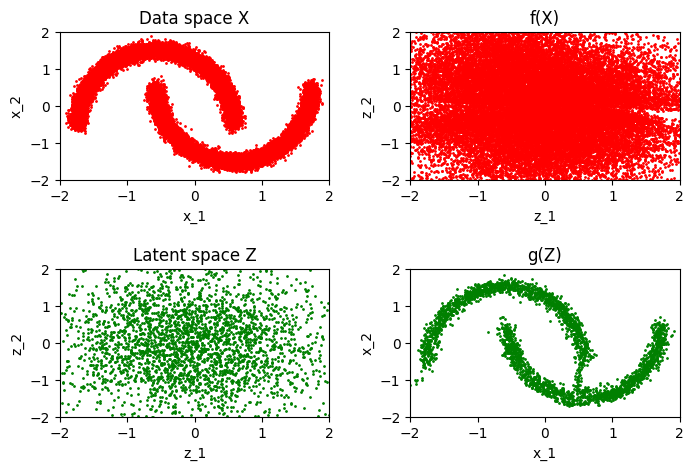

118/118 [==============================] - 4s 36ms/step - loss: 1.2188
Epoch 42/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2032
Epoch 43/300
118/118 [==============================] - 3s 29ms/step - loss: 1.2080
Epoch 44/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2046
Epoch 45/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2054
Epoch 46/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1997
Epoch 47/300
118/118 [==============================] - 3s 27ms/step - loss: 1.2066
Epoch 48/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1987
Epoch 49/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2063
Epoch 50/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2058
Epoch 51/300
118/118 [==============================] - ETA: 0s - loss: 1.2021
Saved to ./output/generated_img_050.png


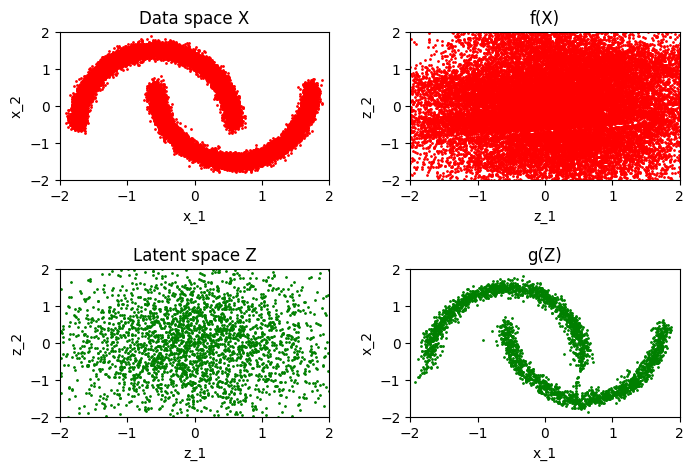

118/118 [==============================] - 5s 43ms/step - loss: 1.2021
Epoch 52/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2015
Epoch 53/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2035
Epoch 54/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1997
Epoch 55/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1972
Epoch 56/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2007
Epoch 57/300
118/118 [==============================] - 3s 22ms/step - loss: 1.2159
Epoch 58/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1996
Epoch 59/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1975
Epoch 60/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1988
Epoch 61/300
118/118 [==============================] - ETA: 0s - loss: 1.2077
Saved to ./output/generated_img_060.png


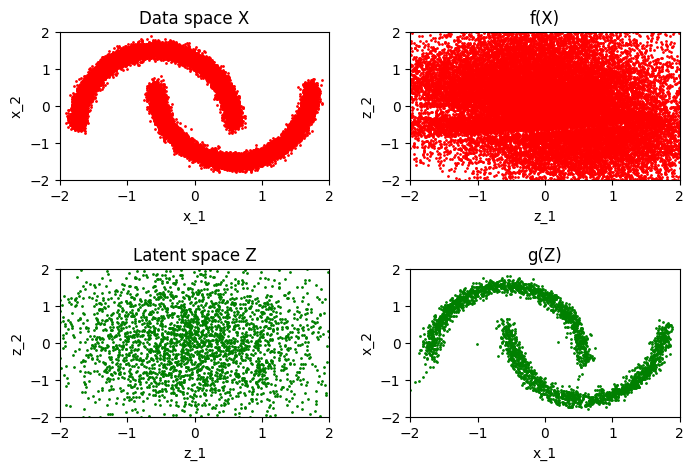

118/118 [==============================] - 4s 35ms/step - loss: 1.2077
Epoch 62/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1923
Epoch 63/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1950
Epoch 64/300
118/118 [==============================] - 3s 27ms/step - loss: 1.2026
Epoch 65/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2006
Epoch 66/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2036
Epoch 67/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1918
Epoch 68/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1897
Epoch 69/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1917
Epoch 70/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1921
Epoch 71/300
118/118 [==============================] - ETA: 0s - loss: 1.1998
Saved to ./output/generated_img_070.png


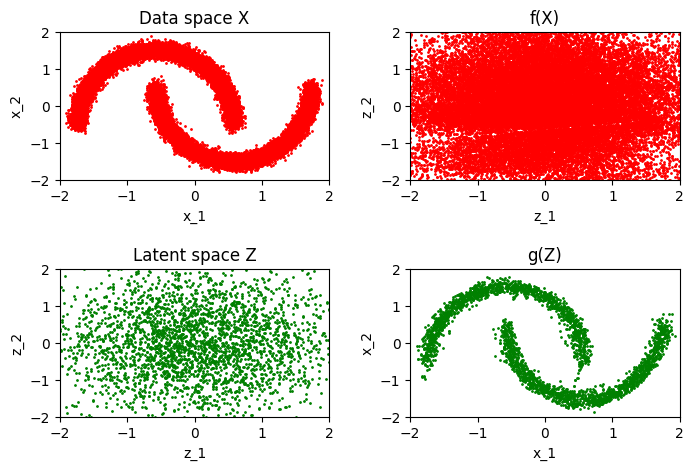

118/118 [==============================] - 5s 40ms/step - loss: 1.1998
Epoch 72/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1891
Epoch 73/300
118/118 [==============================] - 3s 24ms/step - loss: 1.2044
Epoch 74/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1900
Epoch 75/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1909
Epoch 76/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1968
Epoch 77/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1913
Epoch 78/300
118/118 [==============================] - 3s 23ms/step - loss: 1.2010
Epoch 79/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1963
Epoch 80/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1910
Epoch 81/300
118/118 [==============================] - ETA: 0s - loss: 1.1879
Saved to ./output/generated_img_080.png


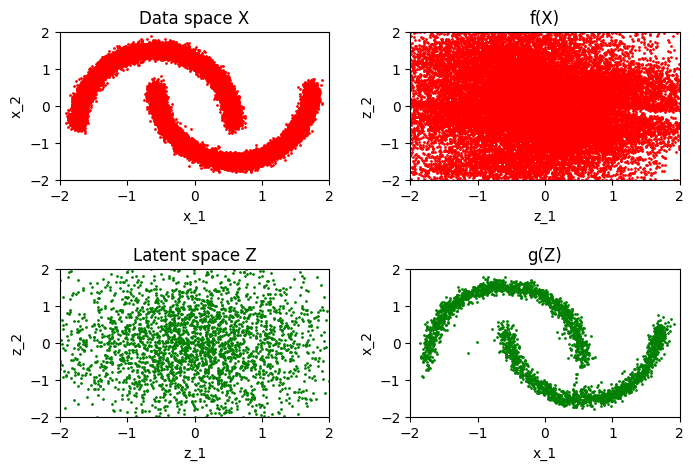

118/118 [==============================] - 4s 38ms/step - loss: 1.1879
Epoch 82/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1898
Epoch 83/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1862
Epoch 84/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1822
Epoch 85/300
118/118 [==============================] - 3s 22ms/step - loss: 1.1865
Epoch 86/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1900
Epoch 87/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1793
Epoch 88/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1837
Epoch 89/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1894
Epoch 90/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1890
Epoch 91/300
117/118 [============================>.] - ETA: 0s - loss: 1.1895
Saved to ./output/generated_img_090.png


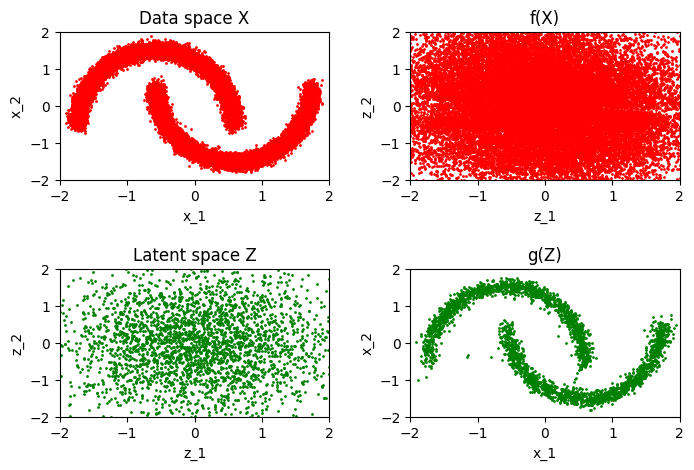

118/118 [==============================] - 4s 38ms/step - loss: 1.1895
Epoch 92/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1829
Epoch 93/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1842
Epoch 94/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1827
Epoch 95/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1863
Epoch 96/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1817
Epoch 97/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1848
Epoch 98/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1834
Epoch 99/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1857
Epoch 100/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1885
Epoch 101/300
117/118 [============================>.] - ETA: 0s - loss: 1.1910
Saved to ./output/generated_img_100.png


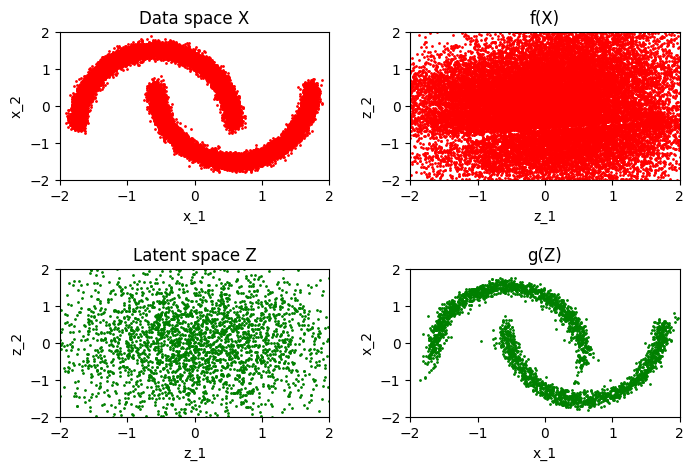

118/118 [==============================] - 5s 40ms/step - loss: 1.1908
Epoch 102/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1821
Epoch 103/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1798
Epoch 104/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1797
Epoch 105/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1867
Epoch 106/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1756
Epoch 107/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1918
Epoch 108/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1840
Epoch 109/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1827
Epoch 110/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1806
Epoch 111/300
118/118 [==============================] - ETA: 0s - loss: 1.1793
Saved to ./output/generated_img_110.png


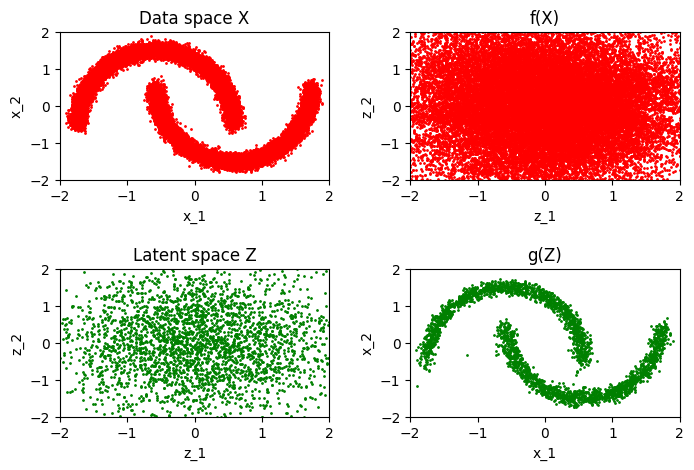

118/118 [==============================] - 4s 34ms/step - loss: 1.1793
Epoch 112/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1749
Epoch 113/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1768
Epoch 114/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1775
Epoch 115/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1793
Epoch 116/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1827
Epoch 117/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1783
Epoch 118/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1786
Epoch 119/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1796
Epoch 120/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1782
Epoch 121/300
117/118 [============================>.] - ETA: 0s - loss: 1.1779
Saved to ./output/generated_img_120.png


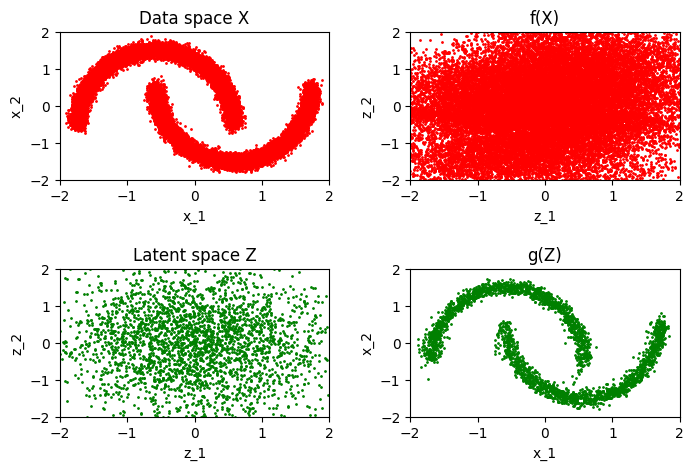

118/118 [==============================] - 5s 45ms/step - loss: 1.1764
Epoch 122/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1763
Epoch 123/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1752
Epoch 124/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1777
Epoch 125/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1765
Epoch 126/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1738
Epoch 127/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1740
Epoch 128/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1714
Epoch 129/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1755
Epoch 130/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1734
Epoch 131/300
116/118 [============================>.] - ETA: 0s - loss: 1.1778
Saved to ./output/generated_img_130.png


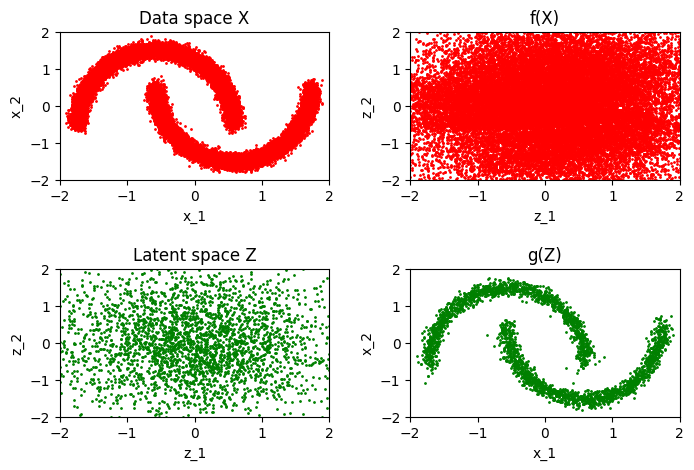

118/118 [==============================] - 4s 36ms/step - loss: 1.1775
Epoch 132/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1727
Epoch 133/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1714
Epoch 134/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1764
Epoch 135/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1719
Epoch 136/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1787
Epoch 137/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1766
Epoch 138/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1792
Epoch 139/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1761
Epoch 140/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1729
Epoch 141/300
117/118 [============================>.] - ETA: 0s - loss: 1.1783
Saved to ./output/generated_img_140.png


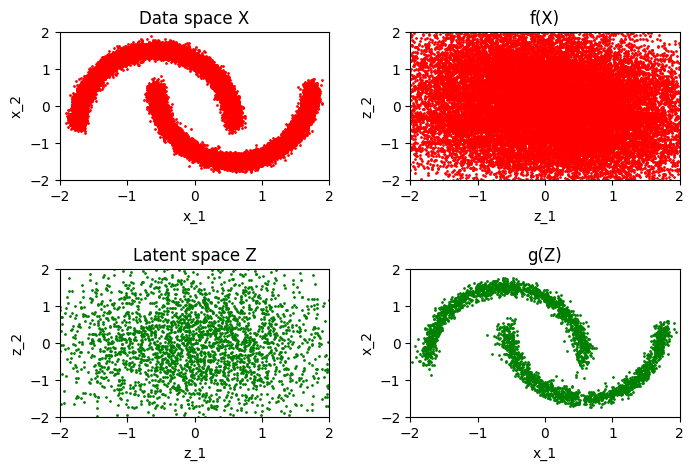

118/118 [==============================] - 5s 46ms/step - loss: 1.1799
Epoch 142/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1810
Epoch 143/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1789
Epoch 144/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1818
Epoch 145/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1722
Epoch 146/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1751
Epoch 147/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1757
Epoch 148/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1748
Epoch 149/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1753
Epoch 150/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1697
Epoch 151/300
118/118 [==============================] - ETA: 0s - loss: 1.1704
Saved to ./output/generated_img_150.png


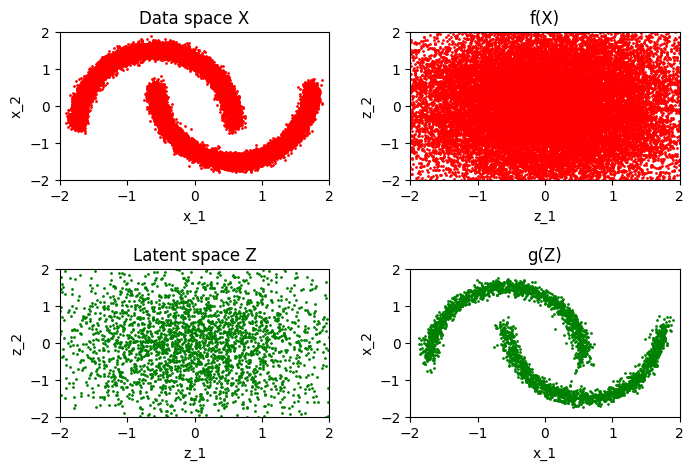

118/118 [==============================] - 4s 37ms/step - loss: 1.1704
Epoch 152/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1796
Epoch 153/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1755
Epoch 154/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1731
Epoch 155/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1720
Epoch 156/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1722
Epoch 157/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1754
Epoch 158/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1754
Epoch 159/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1727
Epoch 160/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1711
Epoch 161/300
118/118 [==============================] - ETA: 0s - loss: 1.1727
Saved to ./output/generated_img_160.png


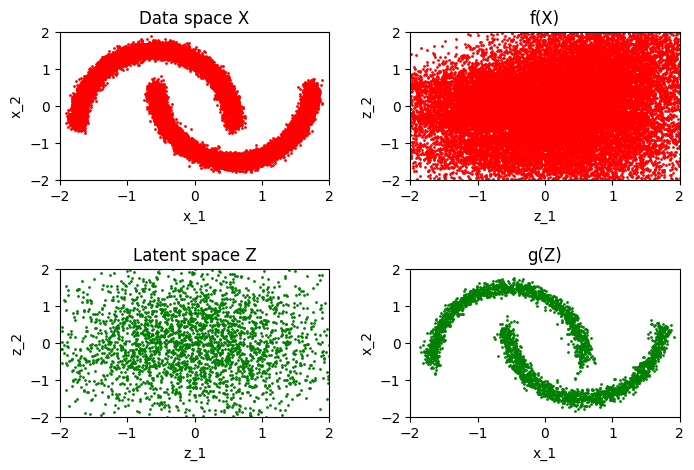

118/118 [==============================] - 6s 48ms/step - loss: 1.1727
Epoch 162/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1844
Epoch 163/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1769
Epoch 164/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1709
Epoch 165/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1718
Epoch 166/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1690
Epoch 167/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1811
Epoch 168/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1697
Epoch 169/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1777
Epoch 170/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1743
Epoch 171/300
117/118 [============================>.] - ETA: 0s - loss: 1.1707
Saved to ./output/generated_img_170.png


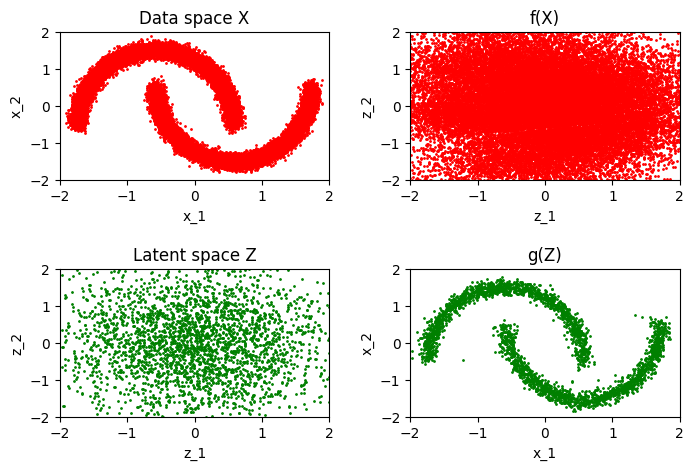

118/118 [==============================] - 4s 38ms/step - loss: 1.1705
Epoch 172/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1687
Epoch 173/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1740
Epoch 174/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1713
Epoch 175/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1717
Epoch 176/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1708
Epoch 177/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1714
Epoch 178/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1728
Epoch 179/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1752
Epoch 180/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1752
Epoch 181/300
118/118 [==============================] - ETA: 0s - loss: 1.1708
Saved to ./output/generated_img_180.png


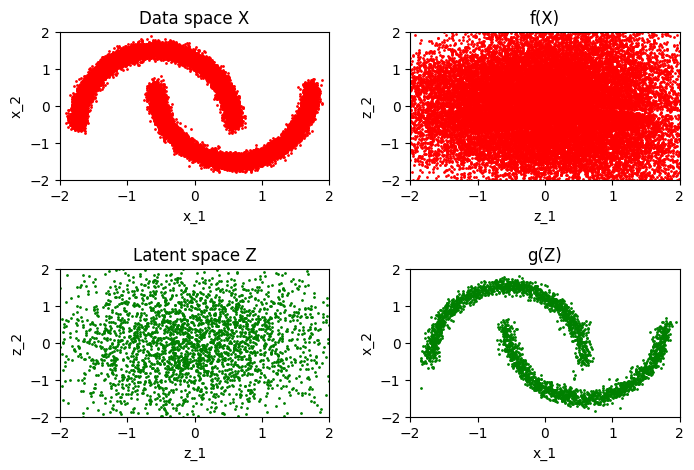

118/118 [==============================] - 5s 46ms/step - loss: 1.1708
Epoch 182/300
118/118 [==============================] - 3s 23ms/step - loss: 1.1733
Epoch 183/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1685
Epoch 184/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1694
Epoch 185/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1732
Epoch 186/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1777
Epoch 187/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1687
Epoch 188/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1728
Epoch 189/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1686
Epoch 190/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1740
Epoch 191/300
118/118 [==============================] - ETA: 0s - loss: 1.1695
Saved to ./output/generated_img_190.png


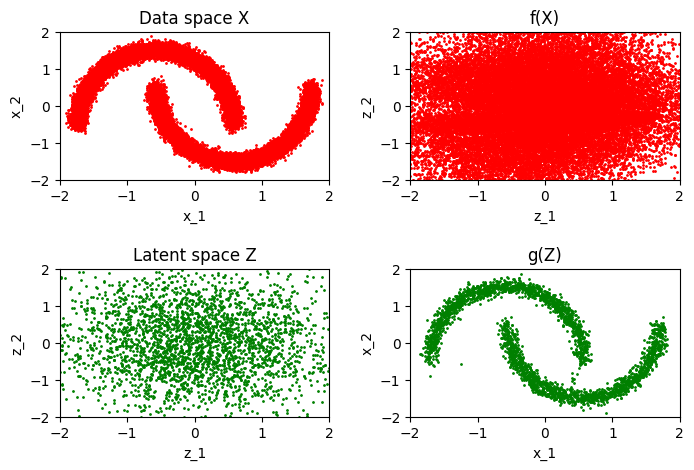

118/118 [==============================] - 4s 37ms/step - loss: 1.1695
Epoch 192/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1712
Epoch 193/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1682
Epoch 194/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1703
Epoch 195/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1717
Epoch 196/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1676
Epoch 197/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1692
Epoch 198/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1746
Epoch 199/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1673
Epoch 200/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1684
Epoch 201/300
118/118 [==============================] - ETA: 0s - loss: 1.1642
Saved to ./output/generated_img_200.png


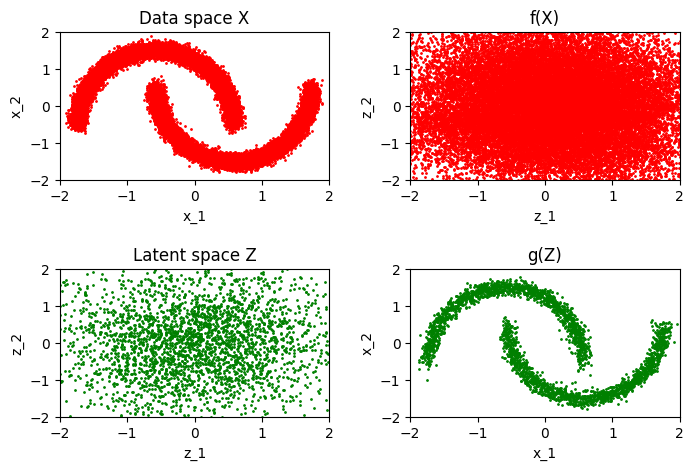

118/118 [==============================] - 5s 39ms/step - loss: 1.1642
Epoch 202/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1679
Epoch 203/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1696
Epoch 204/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1688
Epoch 205/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1700
Epoch 206/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1744
Epoch 207/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1681
Epoch 208/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1743
Epoch 209/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1698
Epoch 210/300
118/118 [==============================] - 4s 33ms/step - loss: 1.1639
Epoch 211/300
116/118 [============================>.] - ETA: 0s - loss: 1.1705
Saved to ./output/generated_img_210.png


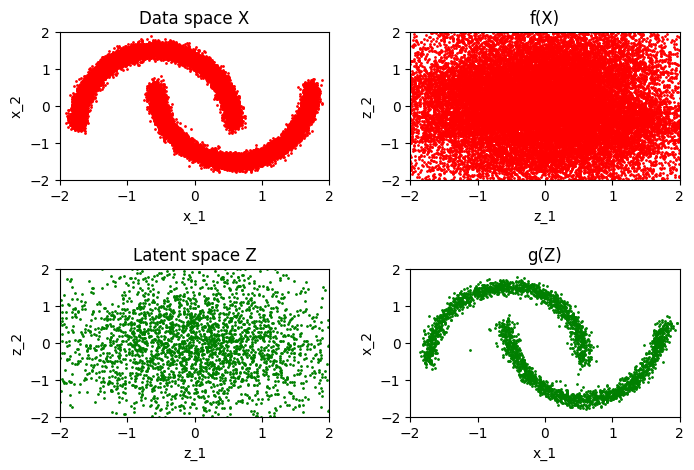

118/118 [==============================] - 4s 38ms/step - loss: 1.1691
Epoch 212/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1636
Epoch 213/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1719
Epoch 214/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1656
Epoch 215/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1733
Epoch 216/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1700
Epoch 217/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1696
Epoch 218/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1636
Epoch 219/300
118/118 [==============================] - 3s 24ms/step - loss: 1.1691
Epoch 220/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1723
Epoch 221/300
118/118 [==============================] - ETA: 0s - loss: 1.1703
Saved to ./output/generated_img_220.png


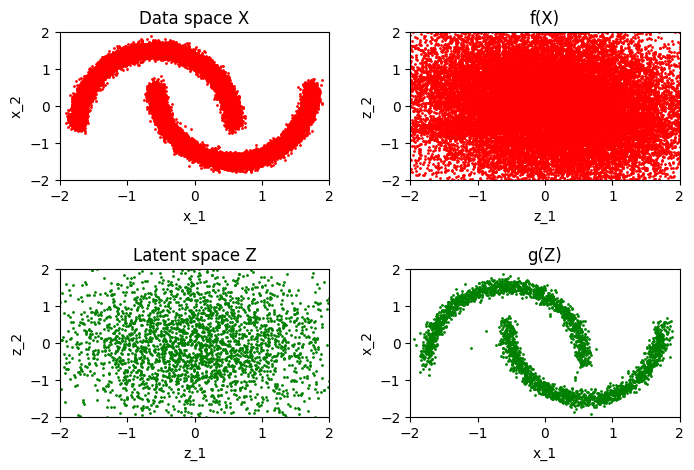

118/118 [==============================] - 5s 44ms/step - loss: 1.1703
Epoch 222/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1716
Epoch 223/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1683
Epoch 224/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1653
Epoch 225/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1668
Epoch 226/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1714
Epoch 227/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1655
Epoch 228/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1649
Epoch 229/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1669
Epoch 230/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1679
Epoch 231/300
118/118 [==============================] - ETA: 0s - loss: 1.1629
Saved to ./output/generated_img_230.png


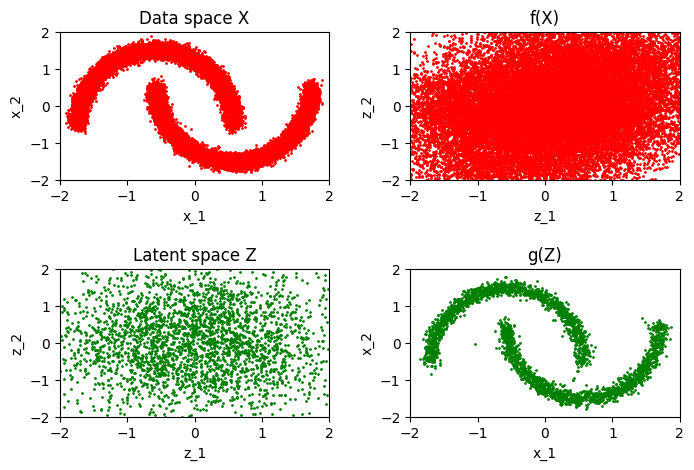

118/118 [==============================] - 5s 40ms/step - loss: 1.1629
Epoch 232/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1664
Epoch 233/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1649
Epoch 234/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1669
Epoch 235/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1635
Epoch 236/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1665
Epoch 237/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1679
Epoch 238/300
118/118 [==============================] - 4s 32ms/step - loss: 1.1676
Epoch 239/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1741
Epoch 240/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1699
Epoch 241/300
117/118 [============================>.] - ETA: 0s - loss: 1.1617
Saved to ./output/generated_img_240.png


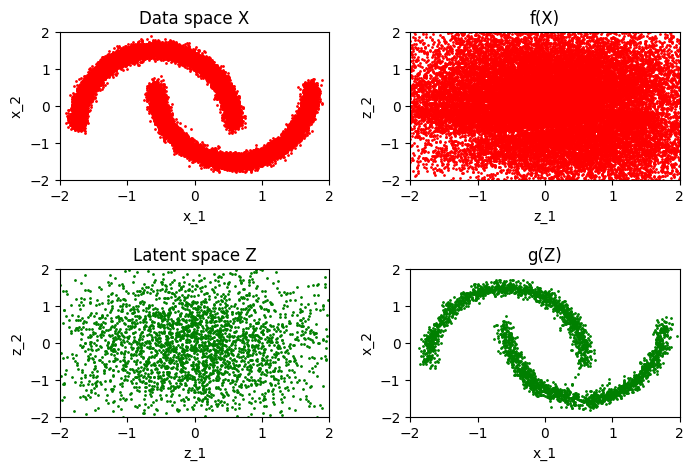

118/118 [==============================] - 5s 46ms/step - loss: 1.1608
Epoch 242/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1713
Epoch 243/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1678
Epoch 244/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1652
Epoch 245/300
118/118 [==============================] - 4s 35ms/step - loss: 1.1684
Epoch 246/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1628
Epoch 247/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1680
Epoch 248/300
118/118 [==============================] - 3s 25ms/step - loss: 1.1671
Epoch 249/300
118/118 [==============================] - 4s 35ms/step - loss: 1.1644
Epoch 250/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1639
Epoch 251/300
117/118 [============================>.] - ETA: 0s - loss: 1.1618
Saved to ./output/generated_img_250.png


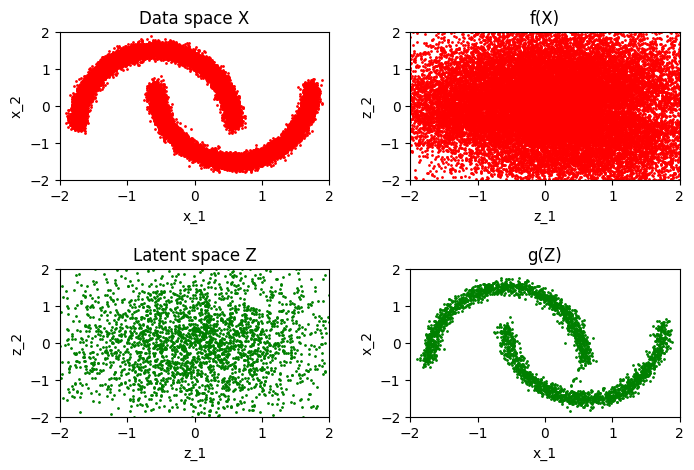

118/118 [==============================] - 5s 39ms/step - loss: 1.1613
Epoch 252/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1664
Epoch 253/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1627
Epoch 254/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1618
Epoch 255/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1693
Epoch 256/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1649
Epoch 257/300
118/118 [==============================] - 4s 35ms/step - loss: 1.1645
Epoch 258/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1698
Epoch 259/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1655
Epoch 260/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1644
Epoch 261/300
118/118 [==============================] - ETA: 0s - loss: 1.1632
Saved to ./output/generated_img_260.png


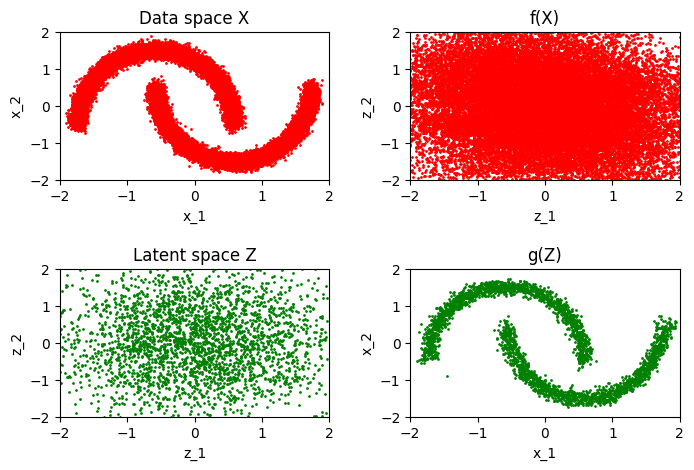

118/118 [==============================] - 5s 43ms/step - loss: 1.1632
Epoch 262/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1643
Epoch 263/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1661
Epoch 264/300
118/118 [==============================] - 4s 32ms/step - loss: 1.1694
Epoch 265/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1645
Epoch 266/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1633
Epoch 267/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1671
Epoch 268/300
118/118 [==============================] - 4s 35ms/step - loss: 1.1656
Epoch 269/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1615
Epoch 270/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1647
Epoch 271/300
118/118 [==============================] - ETA: 0s - loss: 1.1615
Saved to ./output/generated_img_270.png


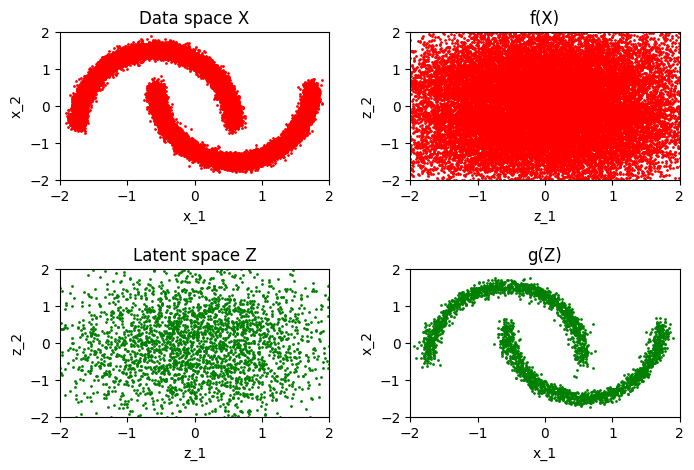

118/118 [==============================] - 5s 40ms/step - loss: 1.1615
Epoch 272/300
118/118 [==============================] - 4s 33ms/step - loss: 1.1644
Epoch 273/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1632
Epoch 274/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1672
Epoch 275/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1687
Epoch 276/300
118/118 [==============================] - 4s 32ms/step - loss: 1.1620
Epoch 277/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1655
Epoch 278/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1654
Epoch 279/300
118/118 [==============================] - 4s 32ms/step - loss: 1.1665
Epoch 280/300
118/118 [==============================] - 4s 31ms/step - loss: 1.1664
Epoch 281/300
118/118 [==============================] - ETA: 0s - loss: 1.1676
Saved to ./output/generated_img_280.png


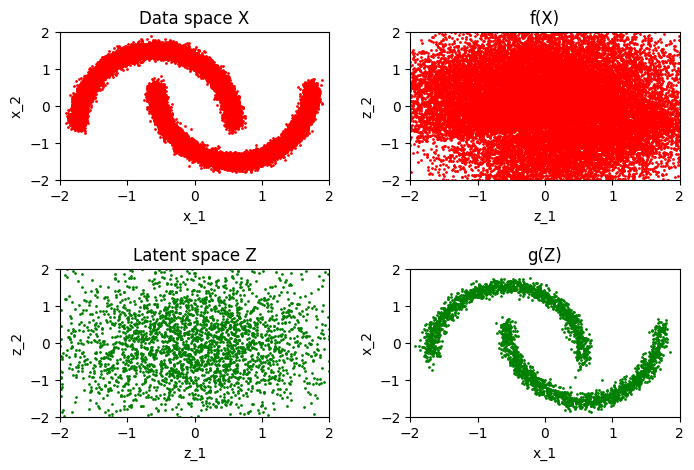

118/118 [==============================] - 5s 39ms/step - loss: 1.1676
Epoch 282/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1687
Epoch 283/300
118/118 [==============================] - 4s 35ms/step - loss: 1.1665
Epoch 284/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1627
Epoch 285/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1661
Epoch 286/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1643
Epoch 287/300
118/118 [==============================] - 4s 36ms/step - loss: 1.1646
Epoch 288/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1701
Epoch 289/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1657
Epoch 290/300
118/118 [==============================] - 3s 26ms/step - loss: 1.1585
Epoch 291/300
118/118 [==============================] - ETA: 0s - loss: 1.1667
Saved to ./output/generated_img_290.png


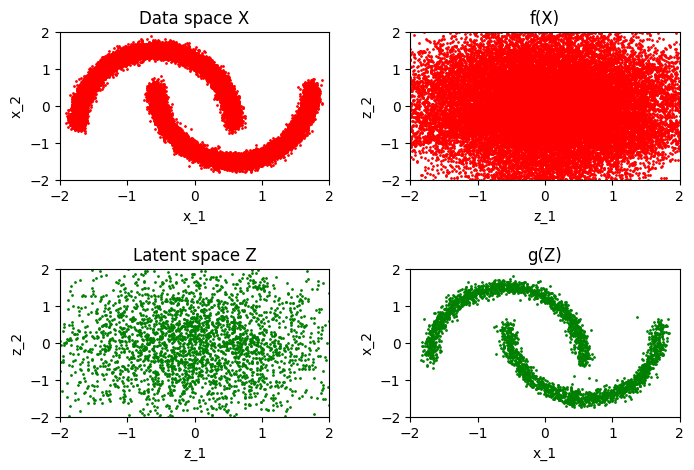

118/118 [==============================] - 6s 50ms/step - loss: 1.1667
Epoch 292/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1642
Epoch 293/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1696
Epoch 294/300
118/118 [==============================] - 4s 32ms/step - loss: 1.1621
Epoch 295/300
118/118 [==============================] - 4s 30ms/step - loss: 1.1665
Epoch 296/300
118/118 [==============================] - 3s 27ms/step - loss: 1.1660
Epoch 297/300
118/118 [==============================] - 3s 29ms/step - loss: 1.1635
Epoch 298/300
118/118 [==============================] - 4s 34ms/step - loss: 1.1637
Epoch 299/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1666
Epoch 300/300
118/118 [==============================] - 3s 28ms/step - loss: 1.1606


In [9]:
model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. 이미지 생성 <a name="generate"></a>

In [10]:
x, z, samples = img_generator_callback.generate()

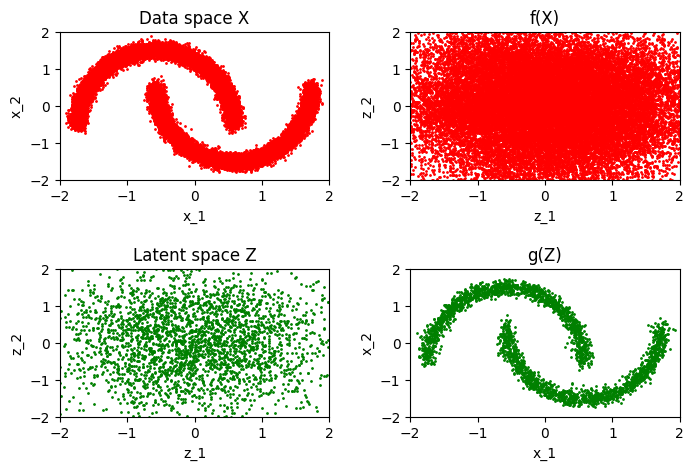

In [11]:
img_generator_callback.display(x, z, samples)